In [1]:
import pandas as pd
import joblib
from data_processing.main import read_scoreset
from tqdm import tqdm
from pathlib import Path
from data_processing.mapping_nbs import mapping_utils
from data_processing.mapping_nbs import plotting
pd.set_option('display.max_columns', 500)

dataset_name = "Gebbia_CHK2"
dataset_path = Path("/data/dzeiberg/mave_calibration/data/") / dataset_name

In [2]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = mapping_utils.load_mapping_data()

In [3]:
scoreset = read_scoreset(dataset_path / "scoreset.csv")

In [4]:
if 'author_transcript' not in scoreset.columns or scoreset.author_transcript.isna().all():
    AUTHOR_TRANSCRIPT = gene_info.loc[metadata.loc[dataset_name],'MANE_RefSeq_nuc'].values[0].split(".")[0]
else:
    AUTHOR_TRANSCRIPT = scoreset.author_transcript.iloc[0].split(".")[0]

In [ ]:
AUTHOR_TRANSCRIPT

# Add ClinVar annotations

In [ ]:
clinvar_hgvs_pro_summaries = mapping_utils.get_clinvar_summaries(clinvar_df,AUTHOR_TRANSCRIPT)

In [7]:
scoreset_w_clinvar = pd.merge(scoreset.set_index("hgvs_pro"),clinvar_hgvs_pro_summaries,
                            left_index=True,
                            right_index=True,
                            how="left",
                            validate="one_to_one",
                            suffixes=("","_clinvar"))

In [ ]:
scoreset_w_clinvar

# Add gnomAD annotations

In [9]:
Ensembl_transcript_stable_ids = mapping_utils.translate_refseq_to_ensembl(AUTHOR_TRANSCRIPT)

In [10]:
gnomAD_info = mapping_utils.gather_gnomAD_info(gnomAD_df,Ensembl_transcript_stable_ids,[AUTHOR_TRANSCRIPT,])

In [11]:
scoreset_processed = pd.merge(scoreset_w_clinvar,gnomAD_info,
                                        left_index=True,right_index=True,how="left",validate="one_to_one").reset_index()

In [12]:
scoreset_processed.to_csv(dataset_path / "scoreset_processed.csv",index=False)

# Reload Processed

In [2]:
scoreset_processed = pd.read_csv(dataset_path / "scoreset_processed.csv")

In [3]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    return r.gnomAD_variants_maxAC_AF > 0 and r.gnomAD_variants_max_spliceAI_score <= .5

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5



In [4]:
sample_data = {
    "P/LP" : scoreset_processed[(scoreset_processed.apply(is_pathogenic,axis=1)) & (scoreset_processed.score.notnull()) & (~scoreset_processed.nonsense)],
    "B/LB" : scoreset_processed[(scoreset_processed.apply(is_benign,axis=1)) & (scoreset_processed.score.notnull()) & (~scoreset_processed.nonsense)],
    'gnomAD': scoreset_processed[(scoreset_processed.apply(is_gnomAD,axis=1)) & (scoreset_processed.score.notnull()) & (~scoreset_processed.nonsense)],
    "synonymous" : scoreset_processed[(scoreset_processed.apply(is_synonymous,axis=1)) & (scoreset_processed.score.notnull())],
}
sample_data = {k : v for k,v in sample_data.items() if len(v) > 0}

In [5]:
for sample_name, sample in sample_data.items():
    print(f"{sample_name}: {sample.shape[0]}")

P/LP: 6
B/LB: 307
gnomAD: 640
synonymous: 334


(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>], dtype=object))

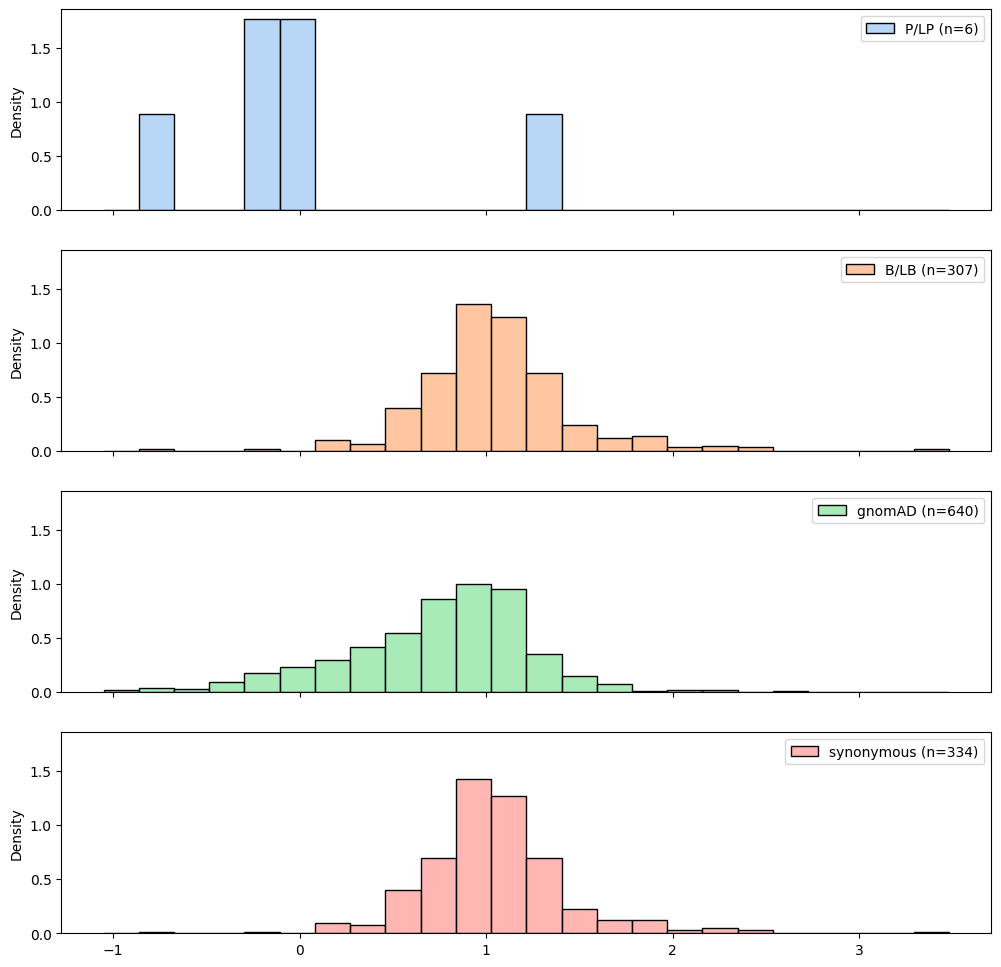

In [6]:
plotting.plot_samples({k : v.score.values for k,v in sample_data.items()})

In [7]:
sample_data['synonymous']

,hgvs_pro,aaChange,type,raw_score,raw_score_error,score,score_se,LLR,LLR_strength,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max,gnomAD_variants_maxAC_AF,gnomAD_variants_max_spliceAI_score,gnomAD_variants_VCF_INFO
0,p.Ser2=,S2S,synonymous,1.09,0.84,1.09,0.84,NaN,NaN,True,False,0.0,1.0,0.0,0.0,NM_007194.4(CHEK2):c.6T>C (p.Ser2=),1.0,0.0,NaN,NaN,NaN
57,p.Glu4=,E4E,synonymous,0.54,0.32,0.54,0.32,NaN,NaN,True,False,0.0,1.0,0.0,0.0,NM_007194.4(CHEK2):c.12G>A (p.Glu4=),1.0,0.0,NaN,NaN,NaN
63,p.Ser5=,S5S,synonymous,0.52,0.52,0.52,0.52,NaN,NaN,True,False,0.0,0.0,1.0,0.0,NM_007194.4(CHEK2):c.15G>A (p.Ser5=),1.0,0.0,NaN,NaN,NaN
141,p.Glu8=,E8E,synonymous,0.98,0.92,0.98,0.92,NaN,NaN,True,False,0.0,1.0,0.0,0.0,NM_007194.4(CHEK2):c.24G>A (p.Glu8=),1.0,0.0,NaN,NaN,NaN
148,p.Ala9=,A9A,synonymous,0.73,0.07,0.73,0.07,-0.12,indeterminate,True,False,0.0,2.0,0.0,0.0,NM_007194.4(CHEK2):c.27T>C (p.Ala9=)|NM_007194...,2.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11290,p.Cys539=,C539C,synonymous,1.17,0.14,1.17,0.14,-0.48,benign supporting,True,False,0.0,1.0,0.0,0.0,NM_007194.4(CHEK2):c.1617T>C (p.Cys539=),1.0,0.0,NaN,NaN,NaN
11299,p.Ala540=,A540A,synonymous,1.84,0.80,1.84,0.80,-0.39,benign supporting,True,False,0.0,2.0,0.0,0.0,NM_007194.4(CHEK2):c.1620T>C (p.Ala540=)|NM_00...,2.0,0.0,NaN,NaN,NaN
11320,p.Ala541=,A541A,synonymous,0.95,0.15,0.95,0.15,-0.38,benign supporting,True,False,0.0,2.0,0.0,0.0,NM_007194.4(CHEK2):c.1623T>C (p.Ala541=)|NM_00...,2.0,0.0,NaN,NaN,NaN
11342,p.Val542=,V542V,synonymous,2.19,1.14,2.19,1.14,-0.59,benign supporting,True,False,0.0,1.0,0.0,0.0,NM_007194.4(CHEK2):c.1626G>A (p.Val542=),1.0,0.0,NaN,NaN,NaN


In [8]:
pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                            *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                            *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values],
                            *[dict(sample_name='synonymous',score=score) for score in sample_data['synonymous'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)